# Results 2a: Data Quality

In [1]:
import os
import numpy as np
from pandas import read_csv

## Section 1: Load and prepare data

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define subscales.
subscales = {
    '7u':    ['7u7d-q01','7u7d-q03','7u7d-q04','7u7d-q06','7u7d-q07','7u7d-q08','7u7d-q13'],
    '7d':    ['7u7d-q02','7u7d-q05','7u7d-q09','7u7d-q10','7u7d-q11','7u7d-q12','7u7d-q14'],
    'gad7':  ['gad7-q01','gad7-q02','gad7-q03','gad7-q04','gad7-q05','gad7-q06','gad7-q07'],
    'pswq':  ['pswq-q01','pswq-q02','pswq-q03'],
    'bis':   ['bisbas-q01','bisbas-q02','bisbas-q03','bisbas-q04'],
    'bas-r': ['bisbas-q05','bisbas-q06','bisbas-q07','bisbas-q08'],
    'bas-d': ['bisbas-q09','bisbas-q10','bisbas-q11','bisbas-q12'],
    'shaps': ['shaps-q01','shaps-q02','shaps-q03','shaps-q04','shaps-q05',
              'shaps-q06','shaps-q07','shaps-q08','shaps-q09','shaps-q10',
              'shaps-q11','shaps-q12','shaps-q13','shaps-q14'],
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load reject data.
reject = read_csv(os.path.join('data','reject.csv'))

## Load survey data.
surveys = read_csv(os.path.join('data','surveys.csv'))

## Restrict participants.
surveys = surveys.loc[surveys.subject.isin(reject.subject)]

## Iteratively compute sum scores.
for i, (k, v) in enumerate(subscales.items()):
    surveys[k] = surveys[v].astype(int).sum(axis=1)
    
## Merge infrequency items.
surveys = surveys.merge(reject[['platform','subject','infreq']])
surveys['infreq'] = np.where(surveys['infreq'], 1, 0)

## Melt DataFrame.
scores = surveys.melt(id_vars=['platform','subject','infreq'], value_vars=subscales.keys(),
                      var_name='survey', value_name='score')

## Section 2: Visualization

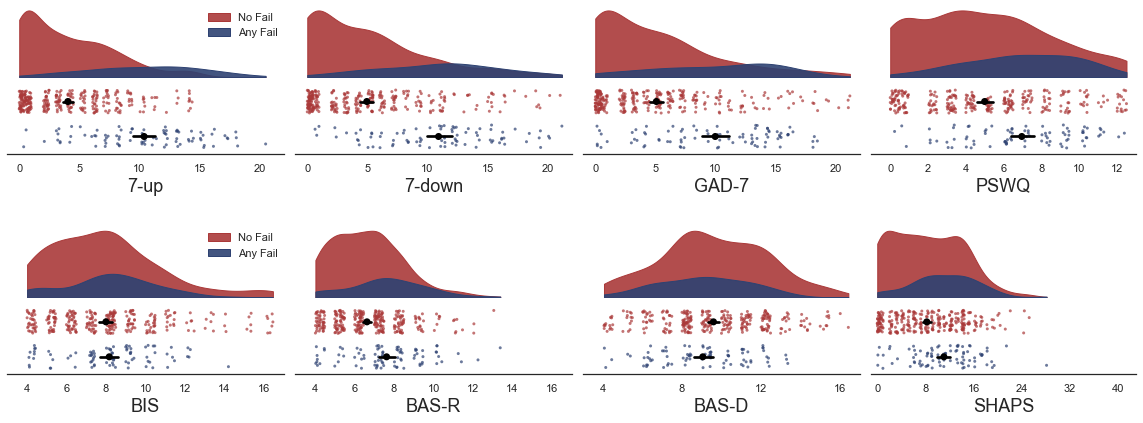

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define order.
order = ['7u','7d','gad7','pswq','bis','bas-r','bas-d','shaps']

## Define titles.
titles = ['7-up', '7-down', 'GAD-7', 'PSWQ', 'BIS', 'BAS-R', 'BAS-D', 'SHAPS']

## Define x-limits.
xlims = [(-1,22),(-1,22),(-1,22),(-1,13),(3,17),(3,17),(3,17),(-1,43)]
xticks = [np.arange(0,21,5),np.arange(0,21,5),np.arange(0,21,5),np.arange(0,13,2),
          np.arange(4,17,2),np.arange(4,17,2),np.arange(4,17,4),np.arange(0,43,8)]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Initialize canvas.
fig = plt.figure(figsize=(16,6))

## Predefine grids.
grids = [
    fig.add_gridspec(nrows=2, ncols=1, top=0.95, bottom=0.61, left=0.01, right=0.25, hspace=0.1),
    fig.add_gridspec(nrows=2, ncols=1, top=0.95, bottom=0.61, left=0.26, right=0.50, hspace=0.1),
    fig.add_gridspec(nrows=2, ncols=1, top=0.95, bottom=0.61, left=0.51, right=0.75, hspace=0.1),
    fig.add_gridspec(nrows=2, ncols=1, top=0.95, bottom=0.61, left=0.76, right=0.99, hspace=0.1),
    fig.add_gridspec(nrows=2, ncols=1, top=0.44, bottom=0.10, left=0.01, right=0.25, hspace=0.1),
    fig.add_gridspec(nrows=2, ncols=1, top=0.44, bottom=0.10, left=0.26, right=0.50, hspace=0.1),
    fig.add_gridspec(nrows=2, ncols=1, top=0.44, bottom=0.10, left=0.51, right=0.75, hspace=0.1),
    fig.add_gridspec(nrows=2, ncols=1, top=0.44, bottom=0.10, left=0.76, right=0.99, hspace=0.1),
]

for i, survey in enumerate(scores.survey.unique()):

    ## Restrict DataFrame.
    df = scores.query(f'survey=="{survey}"').copy()
    
    ## Jitter data.
    unit = np.abs(df.score.diff()).sort_values().unique()[1]
    jitter = lambda x: np.random.uniform(0, unit*0.5, x.size)
    df['jscore'] = np.where(df.score==1, df.score - jitter(df.score), df.score + jitter(df.score))    
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Distribution plots.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Initialize axis.
    ax = fig.add_subplot(grids[i][0])
    
    ## Plot distribution of scores.
    sns.kdeplot(x='jscore', hue='infreq', data=df, hue_order=[1,0], common_grid=True, legend=True,
                palette=['#2E4272','#AA3939'], fill=True, cut=0, alpha=0.9, ax=ax)
    
    ## Add legend.
    ax.legend(ax.legend_.legendHandles[::-1], ['No Fail','Any Fail'], loc=1, 
              borderpad=0, frameon=False)
    if i % 4: ax.legend_.set_visible(False)
    
    ## Add details.
    ax.set(xlim=xlims[i], xticks=[], xlabel='', yticks=[], ylabel='')
    sns.despine(left=True, right=True, top=True, bottom=True, ax=ax)
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Point plots.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Initialize axis.
    ax = fig.add_subplot(grids[i][1])
        
    ## Plot individual scores.
    sns.stripplot(y='infreq', x='jscore', data=df, order=[0,1], orient='h', palette=['#AA3939','#2E4272'],
                   size=3, alpha=0.7, jitter=0.33, zorder=-1, ax=ax)
    
    ## Plot central tendency.
    sns.pointplot(y='infreq', x='jscore', data=df, order=[0,1], orient='h', color='k',
                  markers='o', scale=0.8, join=False, ci=95, edgecolor='k', zorder=10, ax=ax)
    
    ## Add details.
    ax.set(xlim=xlims[i], xticks=xticks[i], yticks=[], ylabel='')
    ax.set_xlabel(titles[i], fontsize=18)
    sns.despine(left=True, ax=ax)
    
## Save figure.
plt.savefig(os.path.join('..','figures','main_02a.png'), dpi=300)